In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from IPython.display import display # データフレーム表示用関数
import seaborn as sns
import pymc as pm
import arviz as az
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## データ分布のベイズ推論

In [2]:
# Code 5.1.1 データの読み込みと確認

df = sns.load_dataset("iris")
display(df.head())

# speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

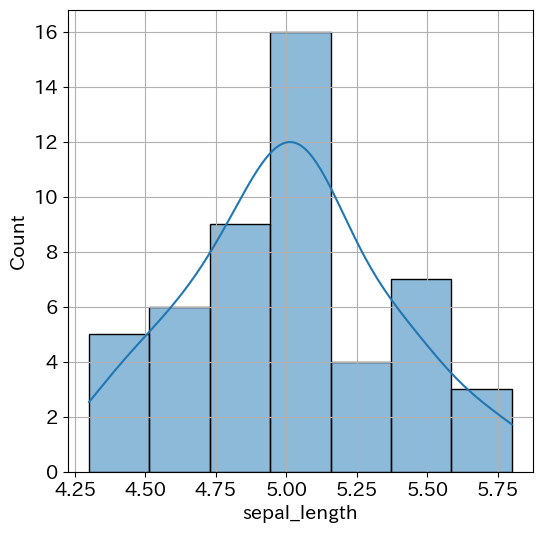

In [3]:
# Code 5.1.2 setosaのがく片長（sepal_length）の分布の可視化

# setosaのレコードを抽出
df1 = df.query('species == "setosa"')

# 可視化
sns.histplot(x="sepal_length", data=df1, kde=True);

このヒストグラムより，アイリスデータセットの特定の花のがく片長の分布は正規分布で近似できそうなので，<br>
パラメータである平均 $\mu$ と分散 $\sigma^2$ をベイズ推論で推定する．

In [4]:
# Code 5.1.3 観測値（observedパラメータ）の抽出と値の確認

# sepal_length列の抽出
s1 = df1["sepal_length"]

# NumPyの１次元配列に変換
X = s1.values

# 統計分析
print(s1.describe())

# 中身の確認
print(X)

count   50.000
mean     5.006
std      0.352
min      4.300
25%      4.800
50%      5.000
75%      5.200
max      5.800
Name: sepal_length, dtype: float64
[5.100 4.900 4.700 4.600 5.000 5.400 4.600 5.000 4.400 4.900 5.400 4.800
 4.800 4.300 5.800 5.700 5.400 5.100 5.700 5.100 5.400 5.100 4.600 5.100
 4.800 5.000 5.000 5.200 5.200 4.700 4.800 5.400 5.200 5.500 4.900 5.000
 5.500 4.900 4.400 5.100 5.000 4.500 4.400 5.000 5.100 4.800 5.100 4.600
 5.300 5.000]


In [5]:
# Code 5.1.4 正規分布の確率モデル定義

model1 = pm.Model()
with model1:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X)

In [ ]:
# Code 5.1.5 確率モデル構造の可視化

g = pm.model_to_graphviz(model1)
display(g)

In [6]:
# Code 5.1.6 デフォルト値でMCMCサンプリング

with model1:
    idata1 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


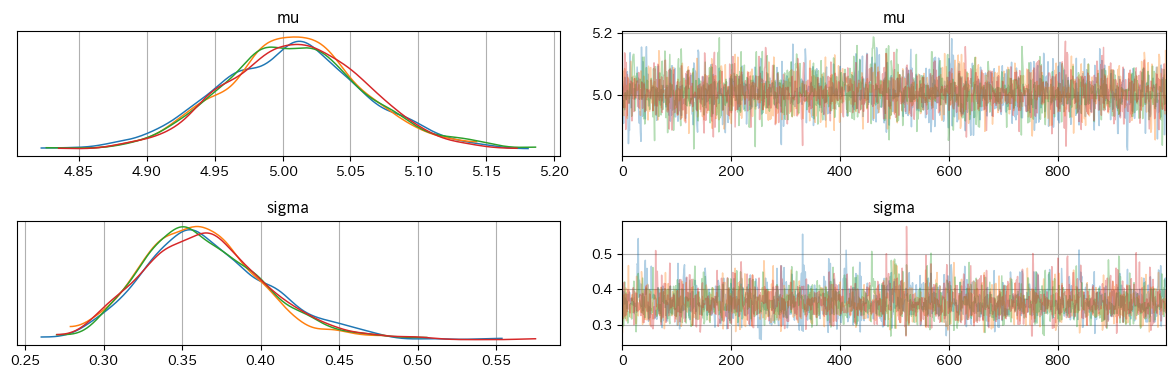

In [7]:
# Code 5.1.7 正常にサンプリングできたか確認

axes = az.plot_trace(idata1, compact=False)
plt.tight_layout();

In [8]:
# Code 5.1.8 idata1の内容確認

idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

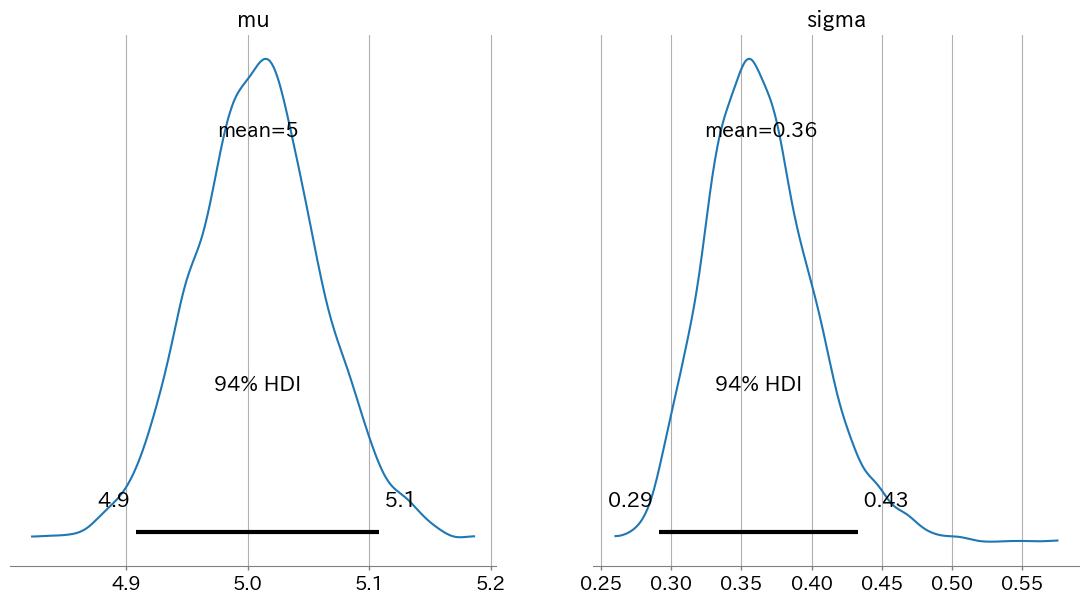

In [9]:
# Code 5.1.9 事後分布の可視化

az.plot_posterior(idata1);

In [10]:
# Code 5.1.10 事後分布の統計分析

summary1 = az.summary(idata1)
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.008,0.053,4.907,5.108,0.001,0.001,3963.000,2164.000,1.000
sigma,0.364,0.039,0.291,0.433,0.001,0.000,3525.000,2781.000,1.000


In [11]:
# summaryデータフレームから各パラメータの平均値を取り出す

mu_mean1 = summary1.loc["mu", "mean"]
sigma_mean1 = summary1.loc["sigma", "mean"]

# 結果確認
print(f"The mean of mu: {mu_mean1}\nThe mean of sigma: {sigma_mean1}")

The mean of mu: 5.008
The mean of sigma: 0.364


平均 $\mu$，分散 $\sigma^2$ の正規分布の確率密度関数：
$$
f(x) = \frac{1}{\sqrt{2\pi}\sigma}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}
$$

In [12]:
# Code 5.1.12 正規分布のPDF

def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

In [13]:
# Code 5.1.13 ベイズ推論結果に基づく理論分布の準備

x_min, x_max = X.min(), X.max()
x_list = np.arange(x_min, x_max+0.01, 0.01)
y_list = norm(x_list, mu=mu_mean1, sigma=sigma_mean1)

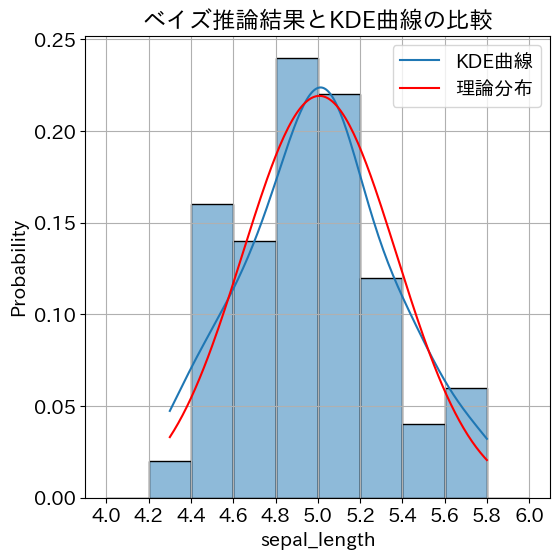

In [14]:
# Code 5.1.14 ベイズ推論結果に基づく理論分布とKDE曲線の描画

delta = 0.2
bins = np.arange(4.0, 6.2, delta)
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df1, x="sepal_length", kde=True, stat="probability", bins=bins)
ax.get_lines()[0].set_label("KDE曲線")
ax.plot(x_list, y_list*delta, c="r", label="理論分布")
ax.set_title("ベイズ推論結果とKDE曲線の比較")
ax.legend()
ax.set_xticks(bins);

### 5.1.7~ 少ないサンプル数でのベイズ推論
ベイズ推論の長所は，サンプルサイズが小さい統計的に厳しい条件でも比較的精度の高い結果を得ることができる点である．<br>
ここでは，サンプルサイズを50から5に減らしてベイズ推論を行う．

In [15]:
# Code 5.1.15 データの絞り込み

# 先頭の5件を取得
X_less = X[:5]

# 中身確認
print(X_less)

# 統計分析
print(pd.Series(X_less).describe())

[5.100 4.900 4.700 4.600 5.000]
count   5.000
mean    4.860
std     0.207
min     4.600
25%     4.700
50%     4.900
75%     5.000
max     5.100
dtype: float64


In [16]:
# Code 5.1.16 確率モデル定義とサンプリング

model2 = pm.Model()
with model2:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X_less)

    # 事後分布のMCMCサンプリング
    idata2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.


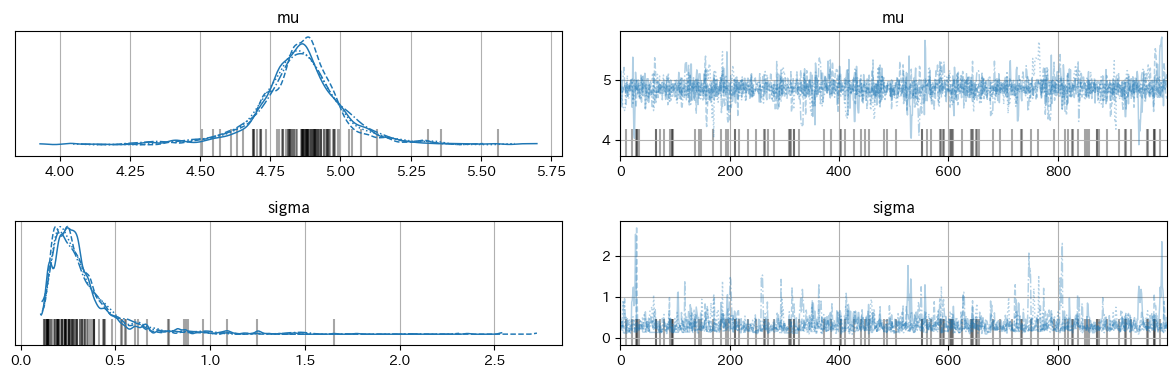

In [17]:
# Code 5.1.16 サンプリングの正常性確認

axes = az.plot_trace(idata2)
plt.tight_layout();

縦のバーが表示されているので，サンプリングの過程で発散が生じていることが確認できる．

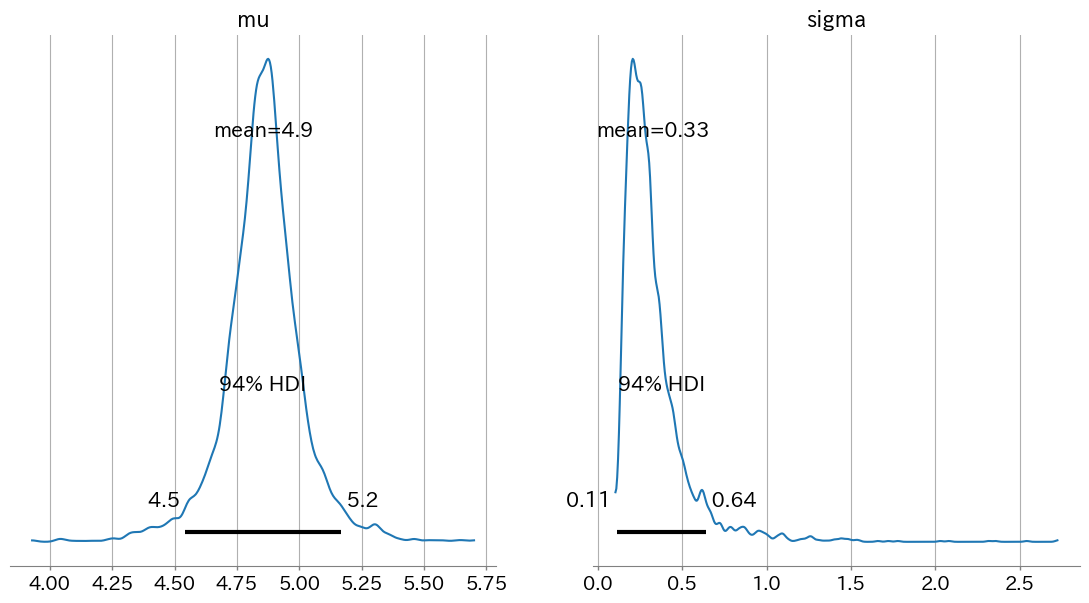

In [18]:
# Code 5.1.17 事後分布の可視化

ax = az.plot_posterior(idata2);

In [19]:
# Code 5.1.18 事後分布の統計分析

summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.854,0.160,4.543,5.167,0.004,0.003,1466.000,1328.000,1.000
sigma,0.328,0.205,0.111,0.639,0.007,0.005,854.000,661.000,1.000


サンプルサイズを1/10に減らしたが，$\mu,\sigma$ ともに平均値は元のサンプルサイズの時の結果と大きく変わらない．一方，94%HDIはかなり広がっている．

In [20]:
# Code 5.1.19 確率モデル定義とサンプリング（tauパラメータを利用した場合）
model3 = pm.Model()

with model3:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfNormal("tau", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X)
    sigma = pm.Deterministic("sigma", 1/pm.math.sqrt(tau))

    # サンプリング
    idata3 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


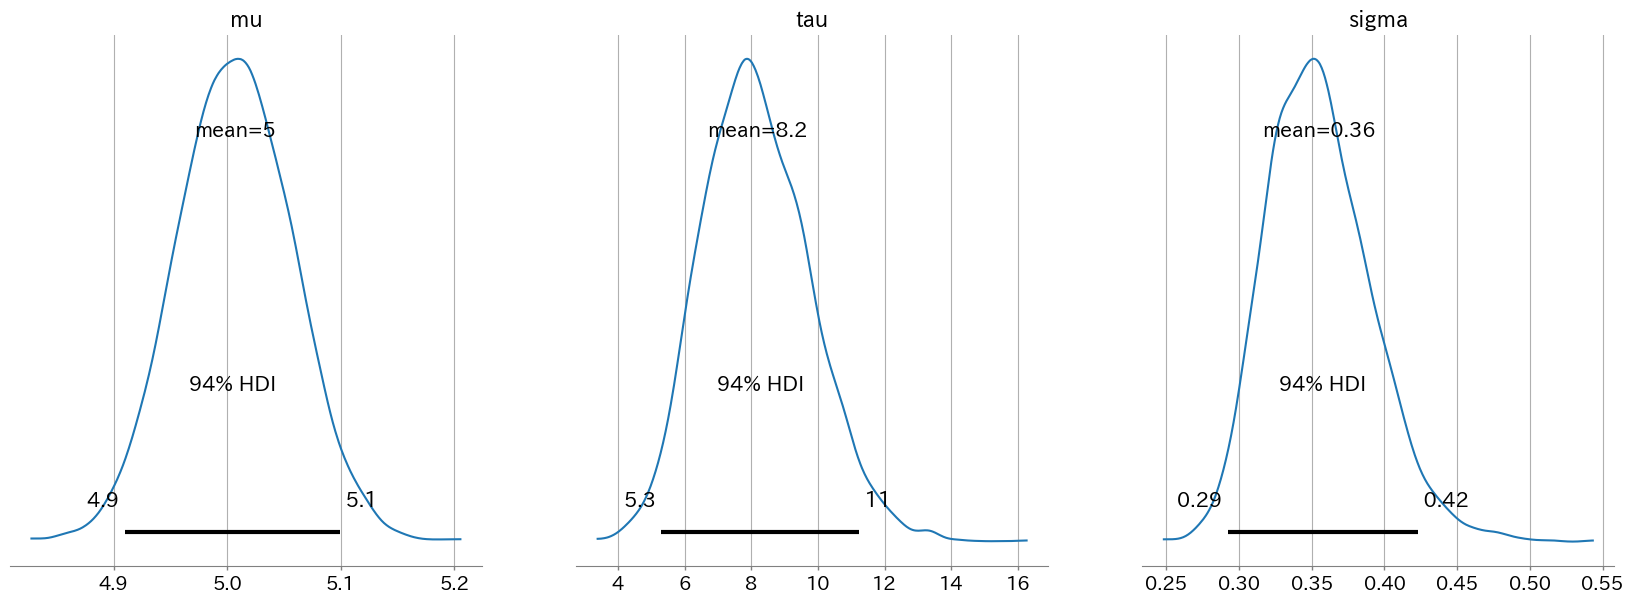

In [21]:
# Code 5.1.20 事後分布の可視化

az.plot_posterior(idata3);